# Project 02. Spanish Translation AB Test

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.tight_layout()

import  warnings
warnings.simplefilter('ignore')

<Figure size 432x288 with 0 Axes>

# Table of Contents
1.

<a id='read_data'></a>
## Read Data

In [3]:
test = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/2. Translation_Test/test_table.csv')
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [5]:
user = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/2. Translation_Test/user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:
user.info()
user.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


<a id='EDA'></a>
## EDA

In [7]:
# check the uniqueness of two tables 
print(test['user_id'].nunique())
print(user['user_id'].nunique())
print(test['user_id'].nunique()-user['user_id'].nunique())

453321
452867
454


There are more data in test table, which means there are some data missing in user table. Merge the two table and make sure all the data in test table are included.

In [8]:
# Merge two tables
data = pd.merge(left=test,right=user,how='left',on='user_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


In [9]:
# Confirm the test is actually negative. First check it is true Spain converts much better than the rest of LatAm countries.
groupby_country = data[data['test']==0].groupby('country')['conversion'].mean().sort_values(ascending=False)
groupby_country

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

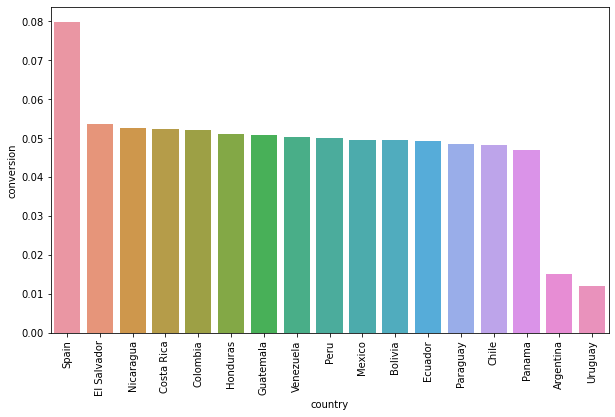

In [11]:
# Visualization of grouby_country
plt.figure(figsize=(10,6))
groupby_country=groupby_country.reset_index()

sns.barplot(x='country',y='conversion',data=groupby_country)
plt.xticks(rotation=90)

It is definitely true that converstion in spain are much better than the other countries.

In [12]:
# Check the conversions of non-spain countries decreased after A/B test
before_AB = data[data['country']!='Spain'][data['test']==0]['conversion'].mean()
after_AB = data[data['country']!='Spain'][data['test']==1]['conversion'].mean()

print('before_AB: ',before_AB, '\n', 'after_AB: ', after_AB)
difference = (before_AB-after_AB)/before_AB
print('Percent decrease: ', '{:0.2%}'.format(float(difference)))

before_AB:  0.04833042316066309 
 after_AB:  0.043424713982118966
Percent decrease:  10.15%


10% drop is really dramatic if it was true. Check the possible reasons for this A/B test results.

In [13]:
# Check the A/B test results difference day by day to see if the difference has been happening all the time or just occasionaly

#to drop the 'Spain' and only keep the countires which has been in test
data=data[data['country'] != 'Spain']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401539 entries, 1 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           401539 non-null  int64  
 1   date              401539 non-null  object 
 2   source            401539 non-null  object 
 3   device            401539 non-null  object 
 4   browser_language  401539 non-null  object 
 5   ads_channel       160984 non-null  object 
 6   browser           401539 non-null  object 
 7   conversion        401539 non-null  int64  
 8   test              401539 non-null  int64  
 9   sex               401085 non-null  object 
 10  age               401085 non-null  float64
 11  country           401085 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 39.8+ MB


In [14]:
# check the drop rate day by day
before_AB_byday = data[data['test']==0].groupby('date')['conversion'].mean()
after_AB_byday = data[data['test']==1].groupby('date')['conversion'].mean()
data['difference']= (before_AB_byday-after_AB_byday)/before_AB_byday

data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country,difference
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico,NaN
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico,NaN
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico,NaN
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela,NaN
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico,NaN


Text(0.5, 1.0, 'Mean Convertion Drop Rate vs Data')

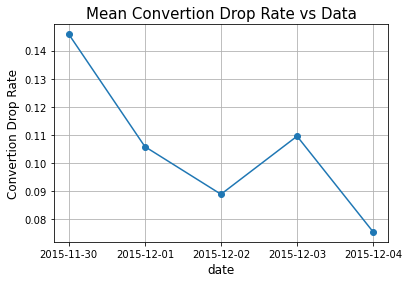

In [15]:
# Visualize the convertion drop rate with the date
before_AB_byday = data[data['test']==0].groupby('date')['conversion'].mean()
after_AB_byday = data[data['test']==1].groupby('date')['conversion'].mean()
difference = (before_AB_byday-after_AB_byday)/before_AB_byday

plt.grid()
plt.plot(difference,marker='o')
plt.ylabel('Convertion Drop Rate',fontsize=12)
plt.xlabel('date',fontsize=12)
plt.title('Mean Convertion Drop Rate vs Data',fontsize=15)

The mean convertion drop rates are basically around 0.1 from the first to the last day, so this dramatic drop should not happen occasionaly. But one thing should be noticed that runing AB test for 5 days is not a good choice since the results could be biased by day-dy-day variations and not representative.  

In [16]:
# check each country how the testing is doing:
from scipy.stats import ttest_ind

countries = [country for country in data['country'].unique() if country is not np.nan]
print('\033[1m'+'{0:14s} {1:10s} {2:13s} {3}'.format('Country','Test-mean','Control-mean','P-value'))

for country in countries:
    test_rate = data[(data['country'] == country) & (data['test'] == 1)]['conversion']
    control_rate = data[(data['country'] == country) & (data['test'] == 0)]['conversion']
    test_mean = test_rate.mean()
    control_mean = control_rate.mean() 
    p_value = ttest_ind(test_rate, control_rate, equal_var=False)
    print('\033[0m'+'{0:12s} {1:11.5f} {2:11.5f} {3:11.5f}'.format(country,test_mean,control_mean, control_mean, p_value))

Country        Test-mean  Control-mean  P-value
Mexico           0.05119     0.04949     0.04949
Venezuela        0.04898     0.05034     0.05034
Bolivia          0.04790     0.04937     0.04937
Colombia         0.05057     0.05209     0.05209
Uruguay          0.01291     0.01205     0.01205
El Salvador      0.04795     0.05355     0.05355
Nicaragua        0.05418     0.05265     0.05265
Peru             0.05060     0.04991     0.04991
Costa Rica       0.05474     0.05226     0.05226
Chile            0.05130     0.04811     0.04811
Argentina        0.01373     0.01507     0.01507
Ecuador          0.04899     0.04915     0.04915
Guatemala        0.04865     0.05064     0.05064
Honduras         0.04754     0.05091     0.05091
Paraguay         0.04923     0.04849     0.04849
Panama           0.04937     0.04680     0.04680


In [17]:
#sal[sal['JobTitle'] . apply ( lambda x : 'chief' in x . lower() . split())] . count()
data['country'].apply(lambda x:data[(data['country'] == x) & (data['test'] == 1)]['conversion'].mean())


1         0.051186
3         0.051186
4         0.051186
5         0.048978
6         0.051186
            ...   
453315    0.051186
453316    0.051186
453317    0.050571
453319    0.050571
453320    0.051186
Name: country, Length: 401539, dtype: float64

## Summary:
    1. To ensure the sampling in A/B testing is as random as possible, A/B tests should run as least one week and two weeks will be better.